# TEST！！！

Steps:
- Determine the noise level sigma (aka. `noise_multiplier`) to reach a total budget of (target_epsilon, target_delta)
  at the end of training, with the given parameters.
- Instantiate a `PrivCostEstimator` object then estimate the ($\varepsilon, q$) mathematical relationship. For example:  
    `pce = PrivCostEstimator(...)`  
    `fit_fn = pce.get_sample_rate_estimator()` 
    
Note that we consider some hyper-parameter values are manually set before the training of the private model begins:
- Number of DPSGD iterations (`num_steps`)
- Per-sample gradients' clipping bound (`max_grad_norm`)
- Target DP parameters (`target_epsilons` and `target_delta`). 

Particularly, in the FL scenarios, the following variables are also considered as the hyper-parameters:
- Number of the communication rounds (`num_rounds`)
- Client-level sampling probability (`client_rate`) 

# Determine the value of `noise_multiplier`
确定噪声水平，根据通过确定目标隐私预算（target_epsilon 和 target_delta）来计算噪声水平。
使用二分搜索法来找到最优的noise_multiplier。

Based on the intuition that records with the maximum sampling probability (i.e., 1.0) will reach the maximum privacy cost than the others with smaller sampling probabilities, we decide to determine the value of `noise_multiplier` via a substitutive parameter `MAX_EPSILON`. 

In [1]:
MAX_EPSILON = 10.0

We plug this parameter conbined with the other fixed ones into the function `get_noise_multiplier` to compute an optimal value of `noise_multiplier` in a binary-search way. 

Note that `get_noise_multiplier` is originally built in the [opacus](https://github.com/pytorch/opacus/blob/main/opacus/accountants/utils.py) package and we further adapt it to the FL applications (see the `myopacus.accountants.utils` module). Please refer to the following example for more details. 

noise_multiplier :  3.50830078125
The R-Squared value of the best-fit curve : 0.9997847663175345
The R-Squared value of the best-fit curve : 0.9994951798048143
The R-Squared value of the best-fit curve : 0.999644249612674
The R-Squared value of the best-fit curve : 0.9997897550664714
The R-Squared value of the best-fit curve : 0.9997835807052826


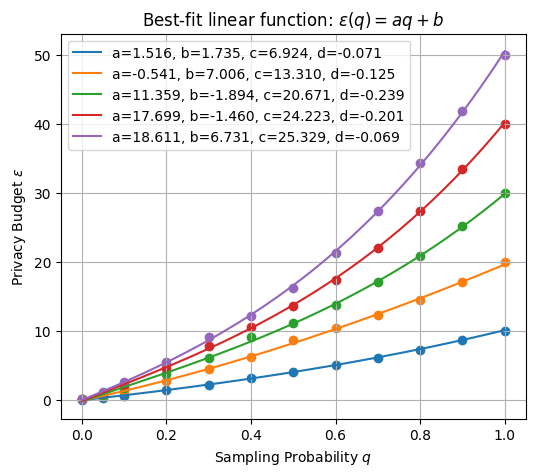

In [2]:
import numpy as np
from pynverse import inversefunc
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pandas as pd

warnings.simplefilter("ignore")

from myopacus.accountants import create_accountant
from myopacus.accountants.rpdp_utils import PrivCostEstimator  # Import PrivCostEstimator

# 其他的参数设置
TARGET_EPSILONS = np.linspace(0.5, 2.0, num=10)
TARGET_DELTA = 1e-3
NUM_STEPS = 5
NUM_ROUNDS = 20
CLIENT_RATE = 0.5
MAX_SIGMA = 1e6
MAX_EPSILON_LIST = [10, 20, 30, 40, 50]  # 多个 MAX_EPSILON 值来测试

# 线性拟合函数（线性关系）
fit_func = {
    "linear1": (lambda x, m, b: m * x + b, lambda m, b: f"{m:.2f}q + {b:.2f}"),  # y = mx + b
    "linear2": (lambda x, m, b, c: m * x + b + c, lambda m, b, c: f"{m:.2f}q + {b:.2f} + {c:.2f}"),  # y = mx + b + c
    "linear3": (lambda x, m, b, c: m * x**2 + b * x + c, lambda m, b, c: f"{m:.2f}q^2 + {b:.2f}q + {c:.2f}"),  # y = mx^2 + bx + c
}

# 计算噪声倍数（noise_multiplier）
def get_noise_multiplier(
        *, 
        target_epsilon, 
        target_delta, 
        sample_rate, 
        epochs=None, 
        steps=None, 
        client_rate=None, 
        rounds=None, 
        accountant="rdp",
        epsilon_tolerance=0.01, 
        **kwargs):
    if (steps is None) == (epochs is None):
        raise ValueError(
            "get_noise_multiplier takes as input EITHER a number of steps or a number of epochs"
        )
    if steps is None:
        steps = int(epochs / sample_rate)

    eps_high = float("inf")
    accountant = create_accountant(mechanism=accountant)

    sigma_low, sigma_high = 0, 10
    while eps_high > target_epsilon:
        sigma_high = 2 * sigma_high
        accountant.history = [(sigma_high, sample_rate, client_rate, rounds, steps)]
        eps_high = accountant.get_epsilon(delta=target_delta, **kwargs)
        if sigma_high > MAX_SIGMA:
            raise ValueError("The privacy budget is too low.")

    while target_epsilon - eps_high > epsilon_tolerance:
        sigma = (sigma_low + sigma_high) / 2
        accountant.history = [(sigma, sample_rate, client_rate, rounds, steps)]
        eps = accountant.get_epsilon(delta=target_delta, **kwargs)

        if eps < target_epsilon:
            sigma_high = sigma
            eps_high = eps
        else:
            sigma_low = sigma

    return sigma_high

noise_multiplier = get_noise_multiplier(
    target_epsilon=MAX_EPSILON,
    target_delta=TARGET_DELTA,
    sample_rate=1.0,
    client_rate=CLIENT_RATE,
    steps=NUM_STEPS,
    rounds=NUM_ROUNDS,
    accountant="fed_rdp"
)
print("noise_multiplier : ", noise_multiplier)

# 根据不同的最大 epsilon 计算噪声倍数
q_eps_fit_param_list = []
q_eps_fit_fn_list = []
examples_list = []
q_candidates = None

for max_epsilon in MAX_EPSILON_LIST:
    nm = get_noise_multiplier(
        target_epsilon=max_epsilon,
        target_delta=TARGET_DELTA,
        sample_rate=1.0,
        client_rate=CLIENT_RATE,
        steps=NUM_STEPS,
        rounds=NUM_ROUNDS,
        accountant="fed_rdp"
    )
    # 通过噪声倍数初始化 PrivCostEstimator
    pce = PrivCostEstimator(
        noise_multiplier=nm, 
        steps=NUM_STEPS, 
        rounds=NUM_ROUNDS, 
        client_rate=CLIENT_RATE,
        delta=TARGET_DELTA
    )
    # 通过 PrivCostEstimator 获取采样率估算函数
    fit_fn = pce.get_sample_rate_estimator()
    if q_candidates is None:
        q_candidates = pce.q_candidates

    # 保存拟合参数和结果
    q_eps_fit_param_list.append(pce.q_eps_fit_param)
    q_eps_fit_fn_list.append(pce.q_eps_fit_fn)
    examples_list.append(pce.examples)

# 展示部分点（观察值）来进行可视化
idx = [1, 49, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189]

# 可视化结果
plt.figure(num=1, figsize=(6, 5), dpi=100, facecolor='w', edgecolor='k')
# Modify the label to handle the correct number of parameters
for i in range(len(q_eps_fit_fn_list)):
    plt.scatter(np.array(q_candidates)[idx], np.array(examples_list[i])[idx], linewidth=1)
    
    # Ensure correct handling of the parameters
    if len(q_eps_fit_param_list[i]) == 2:  # Linear case: m and b
        label = 'a=%5.3f, b=%5.3f' % tuple(q_eps_fit_param_list[i])
    elif len(q_eps_fit_param_list[i]) == 3:  # Quadratic case: m, b, c
        label = 'a=%5.3f, b=%5.3f, c=%5.3f' % tuple(q_eps_fit_param_list[i])
    elif len(q_eps_fit_param_list[i]) == 4:  # Cubic case: m, b, c, d
        label = 'a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(q_eps_fit_param_list[i])
    else:
        label = 'Unknown fit'

    plt.plot(q_candidates, [q_eps_fit_fn_list[i](q) for q in q_candidates], '-', label=label)

plt.title(r'Best-fit linear function: $\varepsilon(q)=aq+b$')
plt.xlabel(rf'Sampling Probability $q$')
plt.ylabel(rf'Privacy Budget $\epsilon$')
plt.legend()
plt.grid(True)
plt.show()



In [3]:
import math
from myopacus.accountants.analysis import rdp as privacy_analysis
from myopacus.accountants.analysis.rdp import _log_add, compute_rdp
from typing import List, Tuple, Union

def _compute_rdp_4fed(inner_rdp: float, client_q: float, rounds: int, alpha: float) -> float:
    r"""
    noise_multiplier: The ratio of the standard deviation of the
            additive Gaussian noise to the L2-sensitivity of the function
            to which it is added.
    """
    if client_q == 1.0: # no client-level privacy amplification
        return inner_rdp * rounds
    else:
        log_term_1 = np.log(1. - client_q)
        log_term_2 = np.log(client_q) + (alpha-1) * inner_rdp
        outer_rdp = _log_add(log_term_1, log_term_2)/(alpha-1)
        return outer_rdp * rounds

def compute_rdp_fed(
    *, q: float, client_q: float, noise_multiplier: float, steps: int, rounds: int, orders: Union[List[float], float]
) -> Union[List[float], float]:
    assert q >= 0.0 and q <= 1.0 and client_q >= 0.0 and client_q <= 1.0, "both the record-level and client-level sampling probability `q` and `client_q` must be a positive real number in [0,1]."
    assert steps >= 1, "The number of iterations of the SGM mechanism `steps` must be a positive integer larger than 1."
    inner_rdps = compute_rdp(q=q, noise_multiplier=noise_multiplier, steps=steps, orders=orders)
    
    if isinstance(orders, float):
        rdp = _compute_rdp_4fed(inner_rdps, client_q, rounds, orders)
    else:
        rdp = np.array([_compute_rdp_4fed(inner_rdp, client_q, rounds, order) 
                        for order, inner_rdp in zip(orders, inner_rdps)])
    return rdp

orders = privacy_analysis.generate_rdp_orders()
rdp = compute_rdp_fed(
    q=0.5, client_q=CLIENT_RATE,
    noise_multiplier=noise_multiplier,
    steps=NUM_STEPS, 
    rounds=NUM_ROUNDS,
    orders=orders
)
rdp


array([1.07433412e+00, 1.73149822e+00, 2.53537238e+00, 3.53050163e+00,
       4.73614297e+00, 6.13200112e+00, 7.66796971e+00, 9.29320472e+00,
       1.09770351e+01, 1.27098666e+01, 1.44943063e+01, 1.63373271e+01,
       1.82463354e+01, 2.02278832e+01, 2.44295511e+01, 2.66577120e+01,
       2.89745993e+01, 3.13819866e+01, 3.64710067e+01, 3.91519115e+01,
       4.47789149e+01, 4.77199865e+01, 5.38409147e+01, 6.02545399e+01,
       6.69279277e+01, 7.38280612e+01, 8.45357294e+01, 9.18720887e+01,
       1.03114405e+02, 1.14584123e+02, 1.26228908e+02, 1.38008087e+02,
       1.53869543e+02, 1.65852521e+02, 1.85940129e+02, 2.02083210e+02,
       2.18269872e+02, 2.38544309e+02, 2.62911283e+02, 2.83235464e+02,
       3.11703898e+02, 3.36111676e+02, 3.64589435e+02, 3.93066452e+02,
       4.25608874e+02, 4.62214718e+02, 4.98815860e+02, 5.39478732e+02,
       5.80136941e+02, 6.28921589e+02, 6.77701518e+02, 7.26477557e+02,
       7.83378893e+02, 8.44340654e+02, 9.05299072e+02, 9.74381977e+02,
      

Then we can obtain the corresponding list of RDP values (we name it as *DP budget curve*) given the desired ``target_delta`` and a list of RDP ``orders``. This computation is based on the "conversion from RDP to (eps, delta)-DP" theorem: If $\mathcal{A}$ is an ($\alpha,\rho$)-RDP mechanism, it also satisfies ($\rho+\frac{\log{1/\delta}}{\alpha-1},\delta$)-DP for any $0<\delta<1$.

- Borja Balle et al. (2020). Hypothesis testing interpretations and Renyi differential privacy. In International Conference on Artificial Intelligence and Statistics (AISTATS). Particullary, Theorem 21 in the [arXiv version](https://arxiv.org/abs/1905.09982).  
- Mironov, I. (2017). Rényi differential privacy. In IEEE Computer Security Foundations Symposium (CSF), Santa Barbara, California, pages 263–275.

In [4]:
orders_vec = np.atleast_1d(orders)
rdp_vec = np.atleast_1d(rdp)
# eps_vec = rdp_vec - math.log(TARGET_DELTA) / (orders_vec - 1)
eps_vec = (
    rdp_vec
    - (np.log(TARGET_DELTA) + np.log(orders_vec)) / (orders_vec - 1)
    + np.log((orders_vec - 1) / orders_vec)
)

Finally, the accumulative privacy cost is exactly the smallest $\varepsilon$ which can be derived by solving the optimization problem 
$$ \varepsilon^* \triangleq \min_{\alpha}\left\{ \rho + \frac{\log(1/\delta)}{\alpha-1}\right\}$$

In [5]:
idx_opt = np.nanargmin(eps_vec)
eps_vec[idx_opt], orders_vec[idx_opt]

(4.0881772775000425, 4)

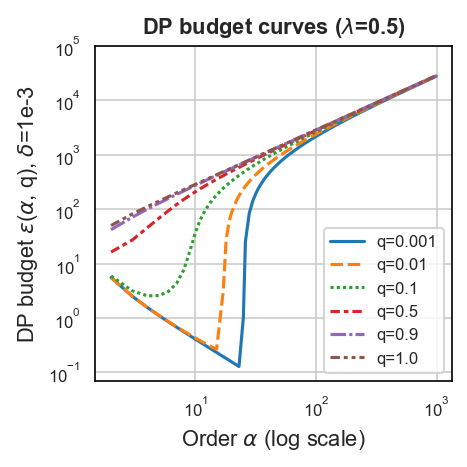

In [6]:
# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 使用 sns 绘制隐私预算与采样概率的关系
q_examples = [0.001, 0.01, 0.1, 0.5, 0.9, 1.0]
eps_vecs = []
for q in q_examples:
    rdp = compute_rdp_fed(
        q=q, client_q=CLIENT_RATE,
        noise_multiplier=nm,
        steps=NUM_STEPS, 
        rounds=NUM_ROUNDS,
        orders=orders
    )
    eps_vecs.append((
        np.atleast_1d(rdp)
        - (np.log(TARGET_DELTA) + np.log(orders_vec)) / (orders_vec - 1)
        + np.log((orders_vec - 1) / orders_vec)
    ))

sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
legend_font = {'style': 'normal', 'size': 8, 'weight': "normal"}
label_font = {'family':'sans-serif', 'size': 10.5, 'weight': "normal"}
title_font = {'family':'sans-serif', 'size': 10.5, 'weight': "bold"}

plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(3, 3), dpi=150, constrained_layout=True)
# dp curve w.r.t. order alpha
colname = [rf'q={q}' for q in q_examples]
df1 = pd.DataFrame(eps_vecs, columns=orders, index=colname)
df1_T = pd.DataFrame(df1.T, columns=colname, index=orders_vec)
sns.lineplot(data=df1_T, ax=axs)
axs.set(xscale="log", yscale="log")
axs.set_ylabel(r'DP budget $\varepsilon$($\alpha$, q), $\delta$=1e-3', **label_font)
axs.set_ylim(0, 100000)
axs.set_xlabel(r'Order $\alpha$ (log scale)', **label_font)
axs.tick_params(labelsize=8)
axs.set_title(rf'DP budget curves ($\lambda$={CLIENT_RATE})', **title_font)
axs.legend(prop=legend_font)
plt.show()

Users can instantiate a `FedRDPAccountant` object and simply invoke the built-in function `get_epsilon` to obtain the accumulative privacy cost in an easy-to-use way.

In [7]:
from myopacus.accountants.fed_rdp import FedRDPAccountant

accountant = FedRDPAccountant()
accountant.history = [(noise_multiplier, 1.0, CLIENT_RATE, NUM_STEPS, NUM_ROUNDS)]
eps = accountant.get_epsilon(delta=TARGET_DELTA)
eps

11.079182321537074

We can see from the above result that if a record's sampling probability is 1.0, its accumulative privacy cost will be around 10.0 (i.e., the value of `MAX_EPSILON` that was previously pre-defined). 

# Use `PrivCostEstimator` to obtain the best-fit sampling probability estimator

After determining the noise_multiplier, we can then compute the corresponding sampling probabilities for all records based on their pre-defined privacy budgets (i.e., `target_epsilons`).

In [8]:
from pynverse import inversefunc
from myopacus.accountants.rpdp_utils import PrivCostEstimator
from sklearn.metrics import r2_score

#使用 PrivCostEstimator 估算采样概率
#在确定了 noise_multiplier 后使用 PrivCostEstimator 来估算采样概率。
#PrivCostEstimator 将基于给定的隐私预算（target_epsilons）来估算每个记录的采样概率。
pce = PrivCostEstimator(
    noise_multiplier = noise_multiplier, 
    steps = NUM_STEPS, 
    rounds = NUM_ROUNDS, 
    client_rate = CLIENT_RATE,
    delta = TARGET_DELTA
)
fit_fn = pce.get_sample_rate_estimator()
sample_rates = [fit_fn(eps) for eps in TARGET_EPSILONS]
list(zip(TARGET_EPSILONS, sample_rates))

The R-Squared value of the best-fit curve : 0.9997847663175345


[(0.5, 0.08074175590341291),
 (0.6666666666666666, 0.10362757670804836),
 (0.8333333333333333, 0.12620248040813553),
 (1.0, 0.14846519294768262),
 (1.1666666666666665, 0.17041545274747652),
 (1.3333333333333333, 0.19205390507816528),
 (1.5, 0.2133820006248526),
 (1.6666666666666665, 0.23440189871305475),
 (1.8333333333333333, 0.2551163790693147),
 (2.0, 0.2755287487193939)]

## The trade-off between noise and sampling error

It is clear that there is a trade-off between the noise and sampling errors: the larger the `MAX_EPSILON`, the smaller the sampling probability (but below 1.0) for all records, as shown in the follwing example.

In [9]:
MAX_EPSILON_LIST = [10, 20, 30, 40, 50]
q_eps_fit_param_list = []
q_eps_fit_fn_list = []
examples_list = []
q_candidates = None
for max_epsilon in MAX_EPSILON_LIST:
    nm = get_noise_multiplier(
        target_epsilon=max_epsilon,
        target_delta=TARGET_DELTA,
        sample_rate=1.0,
        client_rate=CLIENT_RATE,
        steps=NUM_STEPS,
        rounds=NUM_ROUNDS,
        accountant="fed_rdp"
    )
    #用计算出的噪声乘数nm来初始化PrivCostEstimator。这个对象用于估算隐私预算下的采样概率。
    pce = PrivCostEstimator(
        noise_multiplier = nm, 
        steps = NUM_STEPS, 
        rounds = NUM_ROUNDS, 
        client_rate = CLIENT_RATE,
        delta = TARGET_DELTA
    )
    #调用pce.get_sample_rate_estimator()方法来获取一个函数 fit_fn，
    #该函数可以根据隐私预算epsilon来估算采样概率。
    # 假设 TARGET_EPSILONS 是输入，sample_rates 是对应的输出
sample_rates = [fit_fn(eps) for eps in TARGET_EPSILONS]  # 原本的指数拟合，替换掉

# 线性拟合
def linear_fit(x, y):
    params = np.polyfit(x, y, 1)  # 使用numpy.polyfit进行一次线性拟合
    return params

# 对TARGET_EPSILONS和sample_rates进行线性拟合
params = linear_fit(TARGET_EPSILONS, sample_rates)

# 线性拟合的参数：斜率（slope）和截距（intercept）
slope, intercept = params
print(f"线性拟合: y = {slope}x + {intercept}")
    



线性拟合: y = 0.1298505643185269x + 0.01768033369379505


# 尝试线性拟合
                        ε(q)=a⋅q+b


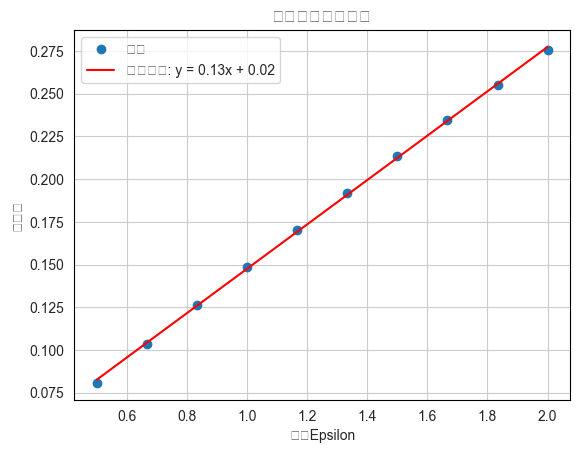

R 方值: 0.9997


In [10]:
import matplotlib.pyplot as plt
plt.plot(TARGET_EPSILONS, sample_rates, 'o', label='数据')  # 原始数据点
plt.plot(TARGET_EPSILONS, slope * TARGET_EPSILONS + intercept, 'r-', label=f'线性拟合: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('目标Epsilon')
plt.ylabel('采样率')
plt.title('线性拟合的采样率')
plt.legend()
plt.show()
# 计算线性拟合的 R 方值
y_pred = slope * TARGET_EPSILONS + intercept
residuals = sample_rates - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((sample_rates - np.mean(sample_rates))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R 方值: {r_squared:.4f}")




# idx = [1, 49, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189]
# # Fit linear model: epsilon(q) = a * q + b
# for i in range(len(examples_list)):
#     # 获取 q_candidates 和 examples_list[i] 的数据
#     x_data = np.array(q_candidates)
#     #y_data = np.array(examples_list[i])
#     #尝试对数据进行对数变换
#     y_data = np.log(np.array(examples_list[i]) + 1)  # 避免负值或零的情况

    
#     # 使用 polyfit 进行线性拟合，返回斜率 a 和截距 b
#     a, b = np.polyfit(x_data, y_data, 1)

#     # 计算拟合的 R² 值
#     r2 = r2_score(y_data, a * x_data + b)
#     # 更新拟合函数，线性拟合的形式
#     q_eps_fit_fn_list[i] = lambda q, a=a, b=b: a * q + b  # 线性函数
    
#     # 保存拟合参数
#     q_eps_fit_param_list[i] = (a, b)

# plt.figure(num=1, figsize=(4, 4), dpi=100, facecolor='w', edgecolor='k')
# for i in range(len(q_eps_fit_fn_list)):
#     plt.scatter(np.array(q_candidates)[idx], np.array(examples_list[i])[idx], linewidth=1)
    
#     # 绘制线性拟合曲线
#     plt.plot(q_candidates, [q_eps_fit_fn_list[i](q) for q in q_candidates], '-', label='a=%5.3f, b=%5.3f' % tuple(q_eps_fit_param_list[i]))

# plt.title(r'Best-fit linear func: $\varepsilon(q)=aq+b$')
# plt.xlabel(rf'Sampling Probability $q$')
# plt.ylabel(rf'Privacy Budget $\epsilon$')
# plt.legend()
# plt.grid(True)
# plt.show()


In [11]:




# idx = [1, 49, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189]
# # Fit linear model: epsilon(q) = a * q + b
# for i in range(len(examples_list)):
#     # 获取 q_candidates 和 examples_list[i] 的数据
#     x_data = np.array(q_candidates)
#     #y_data = np.array(examples_list[i])
#     #尝试对数据进行对数变换
#     y_data = np.log(np.array(examples_list[i]) + 1)  # 避免负值或零的情况

    
#     # 使用 polyfit 进行线性拟合，返回斜率 a 和截距 b
#     a, b = np.polyfit(x_data, y_data, 1)

#     # 计算拟合的 R² 值
#     r2 = r2_score(y_data, a * x_data + b)
#     # 更新拟合函数，线性拟合的形式
#     q_eps_fit_fn_list[i] = lambda q, a=a, b=b: a * q + b  # 线性函数
    
#     # 保存拟合参数
#     q_eps_fit_param_list[i] = (a, b)

# plt.figure(num=1, figsize=(4, 4), dpi=100, facecolor='w', edgecolor='k')
# for i in range(len(q_eps_fit_fn_list)):
#     plt.scatter(np.array(q_candidates)[idx], np.array(examples_list[i])[idx], linewidth=1)
    
#     # 绘制线性拟合曲线
#     plt.plot(q_candidates, [q_eps_fit_fn_list[i](q) for q in q_candidates], '-', label='a=%5.3f, b=%5.3f' % tuple(q_eps_fit_param_list[i]))

# plt.title(r'Best-fit linear func: $\varepsilon(q)=aq+b$')
# plt.xlabel(rf'Sampling Probability $q$')
# plt.ylabel(rf'Privacy Budget $\epsilon$')
# plt.legend()
# plt.grid(True)
# plt.show()


02/26/2025 16:27:38:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


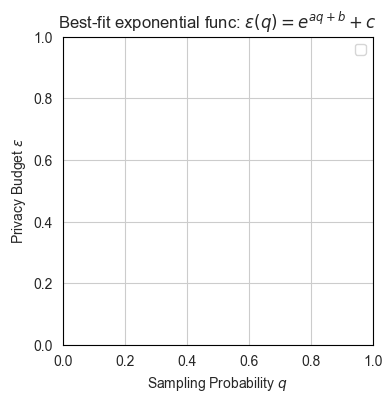

In [12]:
# Here we just demo a subset of points (observations) for a more clear illustration
idx = [1, 49, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189]

plt.figure(num=1, figsize=(4, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(q_eps_fit_fn_list)):
    plt.scatter(np.array(q_candidates)[idx], np.array(examples_list[i])[idx], linewidth=1)
    plt.plot(q_candidates, [q_eps_fit_fn_list[i](q) for q in q_candidates], '-', label='a=%5.3f, b=%5.3f, c=%5.3f' % tuple(q_eps_fit_param_list[i]))

plt.title(r'Best-fit exponential func: $\varepsilon(q)=e^{aq+b}+c$')
plt.xlabel(rf'Sampling Probability $q$')
plt.ylabel(rf'Privacy Budget $\epsilon$')
plt.legend()
plt.grid(True)
plt.show()

We can increase the `noise_multiplier` (which leads to a smaller sampling rate for all records) by increasing the hyper-parameter `MAX_EPSILON`.